## Titanic

Kaggle's Titanic Competition. Aim is to predict Titanic survivors. More info <a href="https://www.kaggle.com/c/titanic">here.</a>

### Table of Contents

1. [Imports](#Imports)    
2. [Data](#Data)  
  2.1 [Import Data](#Import_Data)   
  2.2 [Missing Values](#Missing_Values)  
3. [EDA](#EDA)  
  3.1 [Target](#Target)  
  3.2 [Features](#Features)  
4. [Preprocess](#Preprocess)
5. [Models](#Models)  
  5.1 [Logistic Regression](#Logistic_Regression)  
  5.2 [KNN](#KNN)  
  5.3 [SVM](#SVM)  
  5.4 [Gaussian Naive Bayes](#Gaussian_Naive_Bayes)  
  5.5 [Decision Tree](#Decision_Tree)  
  5.6 [Random Forest](#Random_Forest)  
  5.7 [CatBoost](#CatBoost)  
  5.8 [TensorFlow](#TensorFlow)
6. [Evaluation](#Evaluation)  

### Imports

In [1]:
# main
import numpy as np
import pandas as pd
import scipy.stats as stats
import pickle

# datetimes
import datetime as dt
from datetime import datetime
import time

# dataviz
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

# plot style
%config InteractiveShellApp.pylab_import_all = False
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 7)

plt.style.use('seaborn-colorblind')

# outline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%precision %.3f

# pandas display
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

# warnings
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


### Data

#### Import_Data

In [2]:
df_train = pd.read_csv('../data/titanic_train.csv')
df_test = pd.read_csv('../data/titanic_test.csv')
dfs = [df_train, df_test]

In [3]:
df_all = pd.concat([df_train, df_test], sort=True).reset_index(drop=True)

In [4]:
# data available
len(df_train)
len(df_test)

891

418

In [5]:
df_train.head()
df_test.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


PassengerId : index  
Survived : 0 = No, 1 = Yes  
Pclass : ticket class, 1 = 1st, 2 = 2nd, 3 = 3rd  
Name : -  
Sex : -  
Age : age in years  
SibSp : # of siblings / spouses aboard  
Parch : # of parents / children aboard  
Ticket : ticket num  
Fare : passenger fare  
Cabin : cabin num  
Embarked : port of embarkation, C = Cherbourg, Q = Queenstown, S = Southampton  

#### Missing_Values

In [6]:
df_all.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived          0
Ticket            0
dtype: int64

Text(0.5, 1.0, 'Age wrt Passenger Class and Sex')

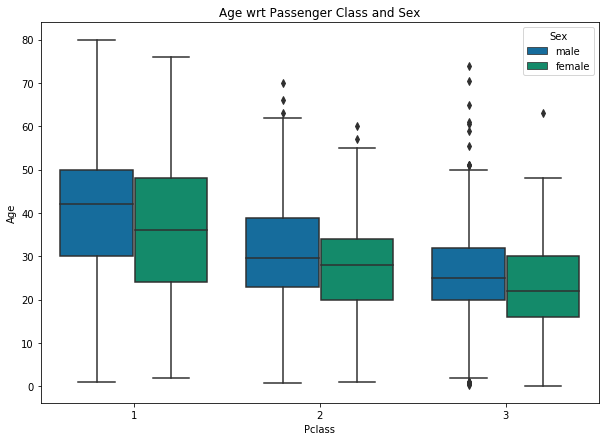

In [7]:
# Age

plt.title('Age wrt Passenger Class and Sex')
sns.boxplot(x='Pclass', y='Age', hue='Sex', data=df_all)

In [8]:
# impute ages wıth medians of Pclass and Sex
age_medians = df_all.groupby(['Sex', 'Pclass']).median()['Age']
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

In [9]:
# Cabin

df_all['Cabin'].isnull().sum()
df_all['Cabin'].isna().mean()

1014

0.774637127578304

In [10]:
# almost 80% of Cabin data is missing, so I'll just get rid of it.
df_all = df_all.drop('Cabin', axis=1)

In [11]:
# Embarked

df_all[df_all['Embarked'].isnull()]

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1,113572
829,62.0,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1,113572


In [12]:
# Googled Icard, Miss. Amelie and got below info.
# She boarded the Titanic at Southampton as maid to Mrs George Nelson Stone. She travelled on Mrs Stone's ticket (#113572).

# fill these two with Embarked = S

df_all['Embarked'] = df_all['Embarked'].fillna('S')

In [13]:
# Fare

df_all[df_all['Fare'].isnull()]

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,0,3701


In [14]:
len(df_all[df_all['Ticket'] == '3701']) # he is the only person with this ticket number

1

In [15]:
# impute fare considering Embarked, PClass and FamilySize
fare_median = df_all[(df_all['Embarked']=='S')&(df_all['Pclass'] == 3)&(df_all['Parch']==0)&(df_all['SibSp']==0)]['Fare'].median()

df_all['Fare'] = df_all['Fare'].fillna(fare_median)

In [16]:
df_all.info()
df_all.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1309 non-null   float64
 1   Embarked     1309 non-null   object 
 2   Fare         1309 non-null   float64
 3   Name         1309 non-null   object 
 4   Parch        1309 non-null   int64  
 5   PassengerId  1309 non-null   int64  
 6   Pclass       1309 non-null   int64  
 7   Sex          1309 non-null   object 
 8   SibSp        1309 non-null   int64  
 9   Survived     1309 non-null   int64  
 10  Ticket       1309 non-null   object 
dtypes: float64(2), int64(5), object(4)
memory usage: 112.6+ KB


,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
count,1309.000000,1309,1309.000000,1309,1309.000000,1309.000000,1309.000000,1309,1309.000000,1309.000000,1309
unique,NaN,3,NaN,1307,NaN,NaN,NaN,2,NaN,NaN,929
top,NaN,S,NaN,"Connolly, Miss. Kate",NaN,NaN,NaN,male,NaN,NaN,CA. 2343
freq,NaN,916,NaN,2,NaN,NaN,NaN,843,NaN,NaN,11
mean,29.261398,NaN,33.276075,NaN,0.385027,655.000000,2.294882,NaN,0.498854,0.382735,NaN
std,13.218275,NaN,51.743642,NaN,0.865560,378.020061,0.837836,NaN,1.041658,0.486240,NaN
min,0.170000,NaN,0.000000,NaN,0.000000,1.000000,1.000000,NaN,0.000000,0.000000,NaN
25%,22.000000,NaN,7.895800,NaN,0.000000,328.000000,2.000000,NaN,0.000000,0.000000,NaN
50%,26.000000,NaN,14.454200,NaN,0.000000,655.000000,3.000000,NaN,0.000000,0.000000,NaN
75%,36.000000,NaN,31.275000,NaN,0.000000,982.000000,3.000000,NaN,1.000000,1.000000,NaN


### EDA

In [17]:
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
df_all.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0,A/5 21171
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1,PC 17599
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1,STON/O2. 3101282
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1,113803
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0,373450


#### Target

In [18]:
df_train['Survived'].value_counts()[1] # survived
df_train['Survived'].value_counts()[0] # not survived
df_train['Survived'].value_counts()[1] / df_train.shape[0] # survived perc
df_train['Survived'].value_counts()[0] / df_train.shape[0] # not survived perc


342

549

0.3838383838383838

0.6161616161616161

#### Features

Text(0.5, 1.0, 'Sex vs Survival')

,Survived
Sex,
female,0.742038
male,0.188908


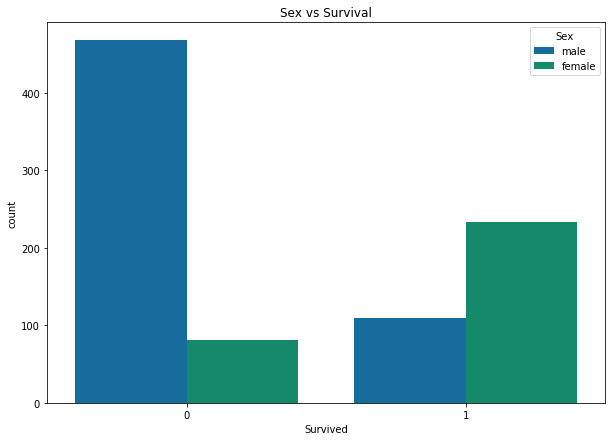

In [19]:
# Sex

plt.title('Sex vs Survival')
sns.countplot(x='Survived',hue='Sex',data=df_train)

df_train[['Sex', 'Survived']].groupby(['Sex']).mean().sort_values(by='Survived', ascending=False)

Text(0.5, 1.0, 'PassengerClass vs Survival')

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


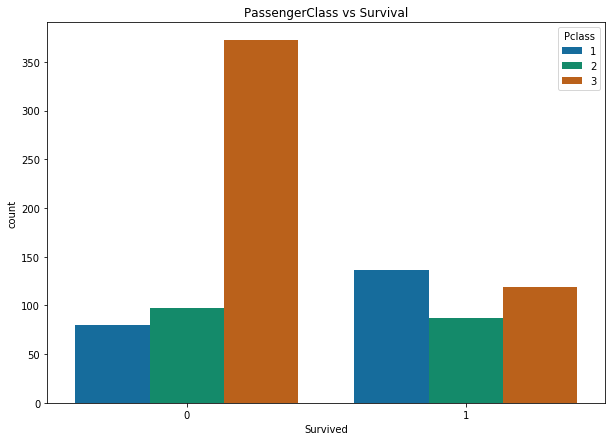

In [20]:
#Pclass

plt.title('PassengerClass vs Survival')
sns.countplot(x='Survived',hue='Pclass',data=df_train)

df_train[['Pclass', 'Survived']].groupby(['Pclass']).mean().sort_values(by='Survived', ascending=False)

In [21]:
# SibSp
df_train[['SibSp', 'Survived']].groupby(['SibSp']).mean().sort_values(by='Survived', ascending=False)

# Parch
df_train[['Parch', 'Survived']].groupby(['Parch']).mean().sort_values(by='Survived', ascending=False)

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


Text(0.5, 1.0, 'Age vs Survival')

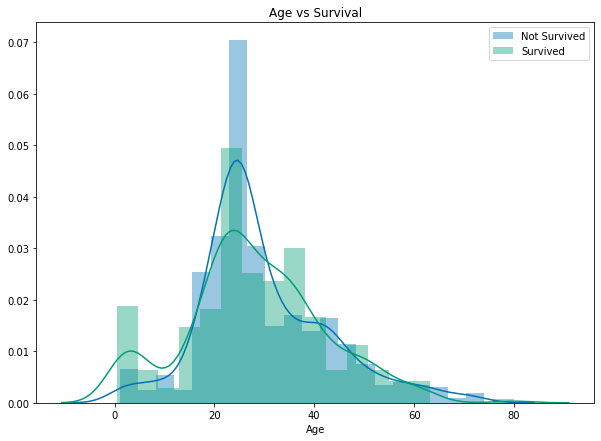

In [22]:
# Age

sns.distplot(df_train[df_train['Survived'] != 1]['Age'], label='Not Survived', hist=True)
sns.distplot(df_train[df_train['Survived'] == 1]['Age'], label='Survived', hist=True)

plt.title('Age vs Survival')
plt.legend(loc='upper right')
plt.show()

Text(0.5, 1.0, 'Fare vs Survival')

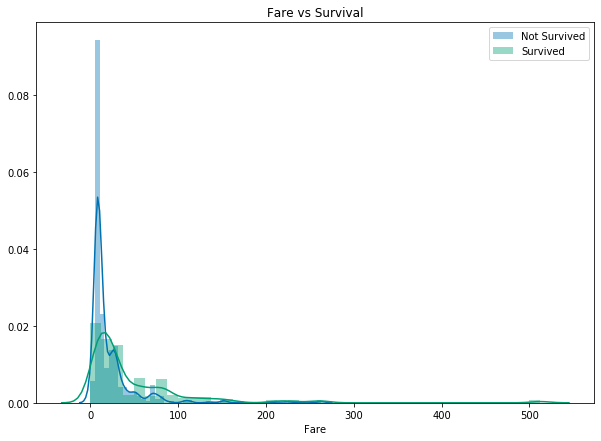

In [23]:
# Fare

sns.distplot(df_train[df_train['Survived'] != 1]['Fare'], label='Not Survived', hist=True)
sns.distplot(df_train[df_train['Survived'] == 1]['Fare'], label='Survived', hist=True)

plt.title('Fare vs Survival')
plt.legend(loc='upper right')
plt.show()

Text(0.5, 1.0, 'Embarked vs Survival')

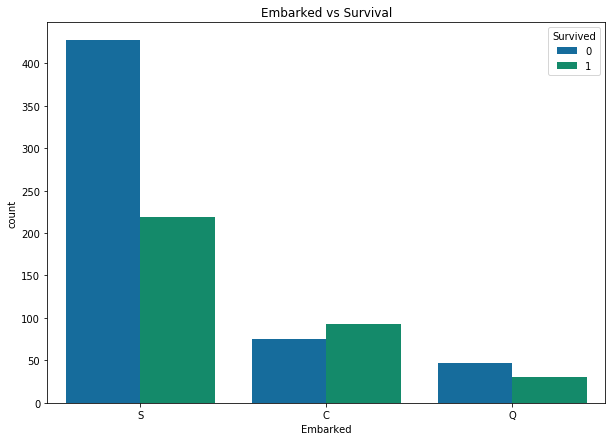

In [24]:
# Embarked

plt.title('Embarked vs Survival')
sns.countplot(x='Embarked', hue='Survived', data=df_train)

Text(0.5, 1.0, 'NumSameTicket vs Survival')

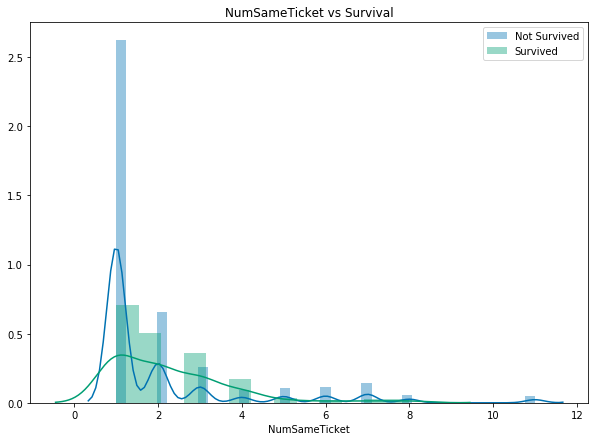

In [25]:
# Ticket

# some ppl have the same ticket num, probably they're family or 1st class' servants etc..
# therefore, not the same thing as SipSp + Parch
    
df_all['NumSameTicket'] = df_all.groupby('Ticket')['Ticket'].transform('count')

# also create in split
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]

sns.distplot(df_train[df_train['Survived'] != 1]['NumSameTicket'], label='Not Survived', hist=True)
sns.distplot(df_train[df_train['Survived'] == 1]['NumSameTicket'], label='Survived', hist=True)

plt.title('NumSameTicket vs Survival')
plt.legend(loc='upper right')
plt.show()

In [26]:
# Name

# we can get some insight from the name field like Mrs, Dr etc...
df_all['Title'] = df_all['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df_all['Title'].value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Major         2
Ms            2
Mlle          2
Jonkheer      1
Don           1
Mme           1
Lady          1
Sir           1
Capt          1
Countess      1
Dona          1
Name: Title, dtype: int64

Text(0.5, 1.0, 'Title vs Survival')

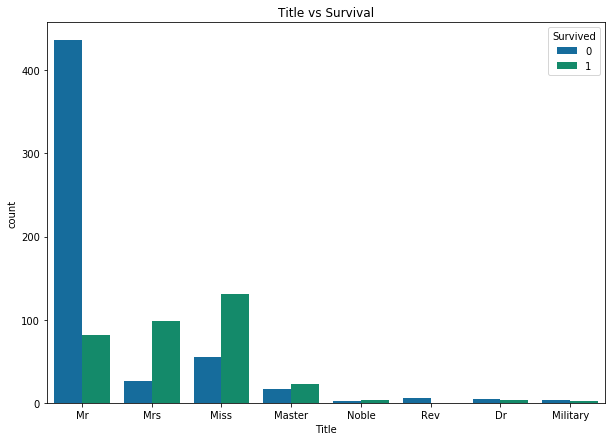

In [27]:
# Title

# clean a bit
df_all['Title'] = df_all['Title'].replace()
df_all['Title'] = df_all['Title'].replace(['Mlle','Ms','Mme', 'Dona'], 'Miss')
df_all['Title'] = df_all['Title'].replace(['Col','Major','Capt'], 'Military')
df_all['Title'] = df_all['Title'].replace(['Lady','Countess','Jonkheer','Sir','Don'], 'Noble')

# also create in split
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]

plt.title('Title vs Survival')
sns.countplot(x='Title', hue='Survived', data=df_train)

### Preprocess

In [28]:
# mapping categorical features
sex_map = {'male': 1, 'female': 2}
title_map = {'Mr': 1, 'Mrs': 2, 'Miss': 3, 'Master': 4, 'Noble': 5, 'Rev': 6, 'Dr': 7, 'Military': 8}
embarked_map = {'S': 1, 'C': 2, 'Q': 3}

df_all['Sex'] = df_all['Sex'].map(sex_map)
df_all['Title'] = df_all['Title'].map(title_map)
df_all['Embarked'] = df_all['Embarked'].map(embarked_map)

In [29]:
drop_cols = ['Name','PassengerId','Ticket']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,NumSameTicket,Title
0,22.0,1,7.2500,0,3,1,1,0,1,1
1,38.0,2,71.2833,0,1,2,1,1,2,2
2,26.0,1,7.9250,0,3,2,0,1,1,3
3,35.0,1,53.1000,0,1,2,1,1,2,2
4,35.0,1,8.0500,0,3,1,0,0,1,1


In [30]:
# get dummies

cat_columns = ['Embarked', 'Pclass', 'Sex', 'Title']

df_all=pd.get_dummies(df_all,columns=cat_columns,drop_first=True)

df_all.head()

,Age,Fare,Parch,SibSp,Survived,NumSameTicket,Embarked_2,Embarked_3,Pclass_2,Pclass_3,Sex_2,Title_2,Title_3,Title_4,Title_5,Title_6,Title_7,Title_8
0,22.0,7.2500,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1,38.0,71.2833,0,1,1,2,1,0,0,0,1,1,0,0,0,0,0,0
2,26.0,7.9250,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0
3,35.0,53.1000,0,1,1,2,0,0,0,0,1,1,0,0,0,0,0,0
4,35.0,8.0500,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [31]:
# also in split
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]

In [32]:
# scale
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(df_train.drop(columns='Survived'))
y_train = df_train['Survived'].values
X_test = sc.transform(df_test.drop(columns='Survived'))
y_test = df_test['Survived'].values

### Models

Try followings for this binary classification problem:

- Logistic Regression
- KNN
- SVM
- Gaussian Naive Bayes Classifier
- Decision Tree
- Random Forrest
- CatBoost Classifier

In [33]:
from sklearn.model_selection import GridSearchCV

#### Logistic_Regression

In [34]:
from sklearn.linear_model import LogisticRegression

# hyperparameters to tune
penalty = ['l1', 'l2']
C = [0.001,.009,0.01,.09,1,5,10,25]
class_weight = ['balanced', None]
solver = ['lbfgs', 'liblinear']

# hyperparameter options
hyperparameters = dict(C=C, penalty=penalty, class_weight=class_weight, solver=solver)

 
# cross-validation
lr = GridSearchCV(estimator=LogisticRegression(), param_grid=hyperparameters, cv=10)

# best model
lr.fit(X_train, y_train)

# best model params
lr.best_params_

# predict using best model
lr_preds = lr.predict(X_test)
score_lr = lr.score(X_train, y_train)
score_lr

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2'],
                         'solver': ['lbfgs', 'liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbo

{'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}

0.835016835016835

#### KNN

In [35]:
from sklearn.neighbors import KNeighborsClassifier

# hyperparameters to tune
leaf_size = [10,15,30,50]
n_neighbors = [3,5,10,15,30]
weights = ['uniform','distance']
p = [1,2]
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']

# hyperparameter options
hyperparameters = dict(leaf_size=leaf_size,n_neighbors=n_neighbors,weights=weights,p=p,algorithm=algorithm)

# cross-validation
knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=hyperparameters, cv=10)

# best model
knn.fit(X_train, y_train)

# best model params
knn.best_params_

# predict using best model
knn_preds = knn.predict(X_test)
score_knn = knn.score(X_train, y_train)
score_knn

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 15, 30, 50],
                         'n_neighbors': [3, 5, 10, 15, 30], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

{'algorithm': 'auto',
 'leaf_size': 10,
 'n_neighbors': 10,
 'p': 1,
 'weights': 'uniform'}

0.8507295173961841

#### SVM

In [36]:
from sklearn.svm import SVC

# hyperparameters to tune
C = [0.5,1,2]
kernel = ['linear', 'rbf']
gamma = [0.02, 0.05]

# hyperparameter options
hyperparameters = dict(C=C,kernel=kernel,gamma=gamma)

# cross-validation
svc = GridSearchCV(estimator=SVC(), param_grid=hyperparameters, cv=10)

# best model
svc.fit(X_train, y_train)

# best model params
svc.best_params_

# predict using best model
svc_preds = svc.predict(X_test)
score_svc = svc.score(X_train, y_train)
score_svc


GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.5, 1, 2], 'gamma': [0.02, 0.05],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

{'C': 1, 'gamma': 0.020, 'kernel': 'linear'}

0.8327721661054994

#### Gaussian_Naive_Bayes

In [37]:
from sklearn.naive_bayes import GaussianNB

# fit model
gs = GaussianNB()
gs.fit(X_train, y_train)
gs_preds = gs.predict(X_test)
score_gs = gs.score(X_train, y_train)
score_gs

GaussianNB(priors=None, var_smoothing=1e-09)

0.4062850729517396

#### Decision_Tree

In [38]:
from sklearn.tree import DecisionTreeClassifier

# hyperparameters to tune
criterion = ['gini','entropy']
splitter = ['best', 'random']
max_depth = [2,4,6,8,None]
min_samples_leaf = [1,3,5,7,10]

# hyperparameter options
hyperparameters = dict(criterion=criterion,splitter=splitter,max_depth=max_depth,min_samples_leaf=min_samples_leaf)

# cross-validation
dt = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=hyperparameters, cv=10)

# best model
dt.fit(X_train, y_train)

# best model params
dt.best_params_

# predict using best model
dt_preds = dt.predict(X_test)
score_dt = dt.score(X_train, y_train)
score_dt


GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                  

{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_leaf': 10,
 'splitter': 'best'}

0.867564534231201

#### Random_Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

# hyperparameters to tune
n_estimators = [100,300]
criterion = ['gini','entropy']
max_depth = [4,8]
max_features = [3,'auto']
min_samples_split = [3,7,10]

# hyperparameter options
hyperparameters = dict(n_estimators=n_estimators,criterion=criterion,max_depth=max_depth,max_features=max_features,min_samples_split=min_samples_split)

# cross-validation
rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=hyperparameters, cv=10)

# best model
rf.fit(X_train, y_train)

# best model params
rf.best_params_

# predict using best model
rf_preds = rf.predict(X_test)
score_rf = rf.score(X_train, y_train)
score_rf


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_split': 7,
 'n_estimators': 300}

0.8810325476992144

#### CatBoost

In [40]:
from catboost import CatBoostClassifier

# hyperparameters to tune
learning_rate = [0.01,0.05,0.1,0.5]
loss_function = ['Logloss', 'CrossEntropy']
l2_leaf_reg = [2,10,25]

# hyperparameter options
hyperparameters = dict(learning_rate=learning_rate,loss_function=loss_function,l2_leaf_reg=l2_leaf_reg)

# cross-validation
cb = GridSearchCV(estimator=CatBoostClassifier(eval_metric='Accuracy',iterations=300), param_grid=hyperparameters, cv=10)

# best model
cb.fit(X_train, y_train, logging_level='Silent')

# best model params
cb.best_params_

# predict using best model
cb_preds = cb.predict(X_test)
score_cb = cb.score(X_train, y_train)
score_cb


GridSearchCV(cv=10, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x1a1e0654d0>,
             iid='deprecated', n_jobs=None,
             param_grid={'l2_leaf_reg': [2, 10, 25],
                         'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'loss_function': ['Logloss', 'CrossEntropy']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

{'l2_leaf_reg': 25, 'learning_rate': 0.050, 'loss_function': 'Logloss'}

0.8911335578002245

#### TensorFlow

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

tf = Sequential()
tf.add(Dense(units=17,activation='relu'))
tf.add(Dense(units=17,activation='relu'))
tf.add(Dense(units=1,activation='sigmoid'))

tf.compile(loss='binary_crossentropy', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
tf.fit(x=X_train, y=y_train, epochs=200,validation_data=(X_test, y_test), verbose=1,callbacks=[early_stop])

Epoch 1/200
28/28 [==============================] - 0s 11ms/step - loss: 0.6322 - val_loss: 0.6027
Epoch 2/200
28/28 [==============================] - 0s 4ms/step - loss: 0.5377 - val_loss: 0.5472
Epoch 3/200
28/28 [==============================] - 0s 4ms/step - loss: 0.4809 - val_loss: 0.5212
Epoch 4/200
28/28 [==============================] - 0s 4ms/step - loss: 0.4510 - val_loss: 0.5114
Epoch 5/200
28/28 [==============================] - 0s 3ms/step - loss: 0.4339 - val_loss: 0.5075
Epoch 6/200
28/28 [==============================] - 0s 4ms/step - loss: 0.4230 - val_loss: 0.5044
Epoch 7/200
28/28 [==============================] - 0s 4ms/step - loss: 0.4155 - val_loss: 0.5031
Epoch 8/200
28/28 [==============================] - 0s 4ms/step - loss: 0.4109 - val_loss: 0.5025
Epoch 9/200
28/28 [==============================] - 0s 4ms/step - loss: 0.4067 - val_loss: 0.5003
Epoch 10/200
28/28 [==============================] - 0s 4ms/step - loss: 0.4015 - val_loss: 0.4991
Epoch 11

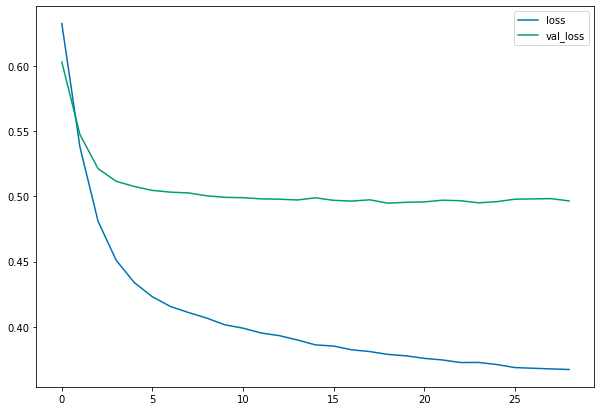

In [42]:
tf_loss = pd.DataFrame(tf.history.history)
tf_loss.plot()

In [43]:
tf_preds = tf.predict_classes(X_test)
tf_preds = tf_preds.reshape(1,418)[0]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


### Evaluation

For evaluation, real y_test values were used. These were not given in Kaggle's competition, instead obtained from Titanic survivors dataset available online.

In [44]:
# evaluate classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# evaluate on

# accuracy = TP + TN / (TP + TN + FP + FN)
# precision = TP / (TP + FP)
# recall = TP / (TP + FN)  aka sensitivity, or true positive rate
# f1 = 2 * precision * recall / (precision + recall) 

In [45]:
models = pd.DataFrame({    
    'Model': [
        'Logistic Regression',
        'KNN', 
        'SVM',
        'Gaussian Naive Bayes',
        'Decision Tree',
        'Random Forest',
        'CatBoost',
        'Tensorflow'
              ],
    
    'Accuracy_Score':[
        accuracy_score(y_test, lr_preds),
        accuracy_score(y_test, knn_preds),
        accuracy_score(y_test, svc_preds),
        accuracy_score(y_test, gs_preds),
        accuracy_score(y_test, dt_preds),
        accuracy_score(y_test, rf_preds),
        accuracy_score(y_test, cb_preds),
        accuracy_score(y_test, tf_preds)
                     ],
    
    'Precision': [
        precision_score(y_test, lr_preds),
        precision_score(y_test, knn_preds),
        precision_score(y_test, svc_preds),
        precision_score(y_test, gs_preds),
        precision_score(y_test, dt_preds),
        precision_score(y_test, rf_preds),
        precision_score(y_test, cb_preds),
        precision_score(y_test, tf_preds)
                ],
    
    'Recall': [
        recall_score(y_test, lr_preds),
        recall_score(y_test, knn_preds),
        recall_score(y_test, svc_preds),
        recall_score(y_test, gs_preds),
        recall_score(y_test, dt_preds),
        recall_score(y_test, rf_preds),
        recall_score(y_test, cb_preds),
        recall_score(y_test, tf_preds)
                ],
    
    'F1_Score': [
        f1_score(y_test, lr_preds),
        f1_score(y_test, knn_preds),
        f1_score(y_test, svc_preds),
        f1_score(y_test, gs_preds),
        f1_score(y_test, dt_preds),
        f1_score(y_test, rf_preds),
        f1_score(y_test, cb_preds),
        f1_score(y_test, tf_preds)
                ],
})

models

,Model,Accuracy_Score,Precision,Recall,F1_Score
0,Logistic Regression,0.767943,0.682353,0.729560,0.705167
1,KNN,0.760766,0.703448,0.641509,0.671053
2,SVM,0.777512,0.701220,0.723270,0.712074
3,Gaussian Naive Bayes,0.394737,0.385922,1.000000,0.556918
4,Decision Tree,0.744019,0.671053,0.641509,0.655949
5,Random Forest,0.787081,0.743056,0.672956,0.706271
6,CatBoost,0.765550,0.701987,0.666667,0.683871
7,Tensorflow,0.779904,0.727891,0.672956,0.699346
